## Composite, non-linear rheology:


The viscous rheology in this model is similar to the Garel et al paper cited below. Other parts of the model setup are similar to Čížková and Bina (2015), Arredondo and Billen (2016) and Korenaga (2011). 

Here we use a dimensionless system. For the psuedo-plastic effective rheology a Drucker-prager model is used.


**Keywords:** subduction, composite rheology, dislocation creep


**References:**


Garel, Fanny, et al. "Interaction of subducted slabs with the mantle transition‐zone: A regime diagram from 2‐D thermo‐mechanical models with a mobile trench and an overriding plate." Geochemistry, Geophysics, Geosystems 15.5 (2014): 1739-1765.

Čížková, Hana, and Craig R. Bina. "Geodynamics of trench advance: Insights from a Philippine-Sea-style geometry." Earth and Planetary Science Letters 430 (2015): 408-415.

Arredondo, Katrina M., and Magali I. Billen. "The Effects of Phase Transitions and Compositional Layering in Two-dimensional Kinematic Models of Subduction." Journal of Geodynamics (2016).

Korenaga, Jun. "Scaling of plate tectonic convection with pseudoplastic rheology." Journal of Geophysical Research: Solid Earth 115.B11 (2010).

In [377]:
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer

import os
import sys
import natsort
import shutil
from easydict import EasyDict as edict
import operator
import pint
import time
import operator
from slippy2 import boundary_layer2d
from slippy2 import material_graph
from slippy2 import spmesh
from slippy2 import phase_function

from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

In [378]:
#store = glucifer.Store('subduction')
#figParticle = glucifer.Figure( store, figsize=(960,300), name="Particles" )

#figParticle.save_database('test.gldb')

Model name and directories
-----

In [379]:
############
#Model name.  
############
Model = "T"
ModNum = 0

if len(sys.argv) == 1:
    ModIt = "Base"
elif sys.argv[1] == '-f':
    ModIt = "Base"
else:
    ModIt = str(sys.argv[1])

In [380]:
###########
#Standard output directory setup
###########


outputPath = "results" + "/" +  str(Model) + "/" + str(ModNum) + "/" + str(ModIt) + "/"
imagePath = outputPath + 'images/'
filePath = outputPath + 'files/'
checkpointPath = outputPath + 'checkpoint/'
dbPath = outputPath + 'gldbs/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '_' + str(ModIt) + '.dat'

if uw.rank()==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(checkpointPath):
        os.makedirs(checkpointPath)
    if not os.path.isdir(imagePath):
        os.makedirs(imagePath)
    if not os.path.isdir(dbPath):
        os.makedirs(dbPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)
        
comm.Barrier() #Barrier here so no procs run the check in the next cell too early

In [381]:
###########
#Check if starting from checkpoint
###########

checkdirs = []
for dirpath, dirnames, files in os.walk(checkpointPath):
    if files:
        print dirpath, 'has files'
        checkpointLoad = True
        checkdirs.append(dirpath)
    if not files:
        print dirpath, 'is empty'
        checkpointLoad = False

results/T/0/Base/checkpoint/ is empty


Setup parameters
-----

Set simulation parameters for test.

**Use pint to setup any unit conversions we'll need**

In [382]:
u = pint.UnitRegistry()
cmpery = 1.*u.cm/u.year
mpermy = 1.*u.m/u.megayear
year = 1.*u.year
spery = year.to(u.sec)
cmpery.to(mpermy)

<Quantity(10000.0, 'meter / megayear')>

In [383]:
box_half_width =4000e3
age_at_trench = 100e6
cmperyear = box_half_width / age_at_trench #m/y
mpersec = cmperyear*(cmpery.to(u.m/u.second)).magnitude #m/sec
print(cmperyear, mpersec )

(0.04, 1.2675505856327397e-11)


**Model flags**

In [384]:
#Modelling and Physics switches
refineMesh = False
stickyAir = False 
meltViscosityReduction = False
symmetricIC = False
sticky_air_temp = 5
eba = False #Flag for extended boussinesq
pressure_correct = False

**Set parameter dictionaries**

In [385]:
###########
#Store the physical parameters, scale factors and dimensionless pramters in easyDicts
#Mainly helps with avoiding overwriting variables
###########


#Style => parameters_like_this

dp = edict({'depth':0.5*2900.*1e3, #Depth
            'LS':2900.*1e3, #Length scale
           'rho':3300.,  #reference density
           'g':9.8, #surface gravity
           'eta0':1e20, #Dislocation creep at 250 km, 1573 K, 1e-15 s-1 
           'k':1e-6, #thermal diffusivity
           'a':3e-5, #surface thermal expansivity
           'TP':1573., #mantle potential temp (K)
           'TS':273., #surface temp (K)
           'cohesion':2e6, #cohesion in Byerlee law
           'fc':0.2,   #friction coefficient in Byerlee law (tan(phi))
           'Adf':3e-11, #pre-exp factor for diffusion creep
           'Ads':5e-16, #pre-exp factor for dislocation creep
           'Apr':1e-150,#pre-exp factor for Peierls creep
           'Edf':3e5,
           'Eds':5.4e5,
           'Epr':5.4e5,
           'Vdf':4e-6,
           'Vds':12e-6,
           'Vpr':10e-6,
           'Alm':2e-16,
           'Elm':2.0e5,
           'Vlm':1.5e-6,
           'Ba':4.3e-12,  #A value to simulate pressure increase with depth
            'BAdT':0.0005, #adiabatic temp gradient used to correct rheology if Boussinesq approx.
           'SR':1e-15,
           #'Dr':250e3, #Reference depth
           'rDepth':250e3, #reference depth (used to scale / normalize the flow laws)
           'R':8.314, #gas constant
           'Cp':1250., #Specific heat (Jkg-1K-1)
           'StALS':100e3, #depth of sticky air layer
           'plate_vel':4})

#Adiabatic heating stuff
if eba:
    #dp.dTa = (dp.a*dp.g*(dp.TP))/dp.Cp #adibatic gradient, at Tp
    dp.dTa = 0.0005 #adibatic gradient, at Tp
else:
    dp.dTa = 0.    
    
dp.deltaTa = (dp.TP + dp.dTa*dp.LS) - dp.TS  #Adiabatic Temp at base of mantle, minus Ts
dp.rTemp= dp.TP + dp.rDepth*dp.dTa #reference temp, (potential temp + adiabat)


#scale_factors

sf = edict({'stress':dp.LS**2/(dp.k*dp.eta0),
            'lith_grad':dp.rho*dp.g*(dp.LS)**3/(dp.eta0*dp.k) ,
            'vel':dp.LS/dp.k,
            'SR':dp.LS**2/dp.k,
            'W':(dp.rho*dp.g*dp.LS)/(dp.R*dp.deltaTa), #This is the activation energy scale
            'E': 1./(dp.R*dp.deltaTa), #using deltaTa, the guesstimated adiabatic temp differnnce to scale these paramters
            #'Ads':(dp.eta0**(ndp.n-2))*((dp.k)**(ndp.n-1))*((dp.LS)**(2. - 2*ndp.n))       
           })

if pressure_correct:
    sf.W = (-1./dp.Ba)*(np.log(1.-dp.rho*dp.g*dp.Ba*dp.LS))/(dp.R*dp.deltaTa),

#dimensionless parameters

ndp = edict({'RA':(dp.g*dp.rho*dp.a*dp.deltaTa*(dp.LS)**3)/(dp.k*dp.eta0),
            'cohesion':dp.cohesion*sf.stress,
            'fcd':dp.fc*sf.lith_grad,
            'gamma':dp.fc/(dp.a*dp.deltaTa),
            'Wdf':dp.Vdf*sf.W,
            'Edf':dp.Edf*sf.E,
            'Wps':dp.Vpr*sf.W,
            'Eps':dp.Epr*sf.E,
            'Wds':dp.Vds*sf.W,
            'Eds':dp.Eds*sf.E,
            'Elm':dp.Elm*sf.E,
            'Elm':dp.Elm*sf.E,
            'Wlm':dp.Vlm*sf.W,
            'TSP':0., 
            'TBP':1.,
            'TPP':(dp.TP - dp.TS)/dp.deltaTa, #dimensionless potential temp
            'rDepth':dp.rDepth/dp.LS,
            'rTemp':(dp.rTemp- dp.TS)/dp.deltaTa,
            'n':3.5, #Dislocation creep stress exponent
            'np':20., #Peierls creep stress exponent
            'TS':dp.TS/dp.deltaTa,
            'TP':dp.TP/dp.deltaTa,
            'eta_min':1e-3, 
            'eta_max':1e5, #viscosity max in the mantle material
            'eta_max_crust':0.3, #viscosity max in the weak-crust material
            'H':0.,
            'Di': dp.a*dp.g*dp.LS/dp.Cp, #Dissipation number
            'Steta0':1e-2,
            'plate_vel':sf.vel*dp.plate_vel*(cmpery.to(u.m/u.second)).magnitude,
            'low_mantle_visc_fac':1.,
            'crust_cohesion_fac':1.,
            'crust_fc_fac':0.01})

#Make some further additions to paramter dictionaries

#dp.VR = (0.1*(dp.k/dp.LS)*ndp.RA**(2/3.)) #characteristic velocity from a scaling relationship
#dp.SR = dp.VR/dp.LS #characteristic strain rate
#ndp.VR = dp.VR*sf.vel #characteristic velocity
#ndp.SR = dp.SR*sf.SR #characteristic strain rate


ndp.SR = dp.SR*sf.SR #characteristic strain rate

ndp.StRA = (3300.*dp.g*(dp.LS)**3)/(dp.eta0 *dp.k) #Composisitional Rayleigh number for rock-air buoyancy force
ndp.TaP = 1. - ndp.TPP,  #Dimensionless adiabtic component of deltaT

In [386]:
#27.37 * ( dp.deltaTa/1300.)
ndp.Wdf


34.709202272348776

In [387]:
###########
#lengths scales for various processes (material transistions etc.)
###########

MANTLETOCRUST = (10.*1e3)/dp.LS #Crust depth
HARZBURGDEPTH = MANTLETOCRUST + (27.7e3/dp.LS)
CRUSTTOMANTLE = (800.*1e3)/dp.LS
LITHTOMANTLE = (900.*1e3)/dp.LS 
MANTLETOLITH = (200.*1e3)/dp.LS 
TOPOHEIGHT = (10.*1e3)/dp.LS  #rock-air topography limits
CRUSTTOECL  = (100.*1e3)/dp.LS
AVGTEMP = ndp.TPP #Used to define lithosphere
LOWMANTLEDEPTH = (660.*1e3)/dp.LS 
CRUSTVISCUTOFF = (150.*1e3)/dp.LS #Deeper than this, crust material rheology reverts to mantle rheology
AGETRACKDEPTH = 100e3/dp.LS #above this depth we track the age of the lithsphere (below age is assumed zero)


**Model/ mesh  setup parameters**

In [388]:
###########
#Model setup parameters
###########

compBuoyancy = False #use compositional & phase buoyancy, or simply thermal
viscMechs = ['diffusion', 'dislocation', 'peierls', 'yielding']
viscCombine = 'harmonic' #'harmonic', 'min', 'mixed'....

#Domain and Mesh paramters

RES = 128

VelBC = False
if dp.depth == 2900.e3:
    aspectRatio = 10000e3/dp.depth
    Xres = RES*4
elif dp.depth == 0.5*2900.e3:
    aspectRatio = 10000e3/dp.depth
    Xres = RES*8
else:
    print ("depth should be 2900km, or 1450 km")

dim = 2          # number of spatial dimensions
hw = np.round(5000e3/dp.LS, 1)
MINX = -1*hw
MINY = 1. - (dp.depth/dp.LS)


MAXX = hw
MAXY = 1.


if stickyAir:
    Yres = RES
    MAXY = 1. + dp.StALS/dp.LS #150km
    
else:
    Yres = RES
    MAXY = 1.

periodic = [False, False]
elementType = "Q1/dQ0"
#elementType ="Q2/DPC1"


#System/Solver stuff
PIC_integration=True
ppc = 25

#Metric output stuff
figures =  'gldb' #glucifer Store won't work on all machines, if not, set to 'gldb' 
swarm_repop, swarm_update = 10, 10
gldbs_output = 20
checkpoint_every, files_output = 20, 20 #checkpoint every needs to be greater or equal to metric_output 
metric_output = 10


In [389]:
dp.dTa

0.0

Create mesh and finite element variables
------

In [390]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType),
                                 elementRes  = (Xres, Yres), 
                                 minCoord    = (MINX, MINY), 
                                 maxCoord    = (MAXX, MAXY), periodic=periodic)

velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

In [391]:
mesh.reset()


In [392]:
###########
#Mesh refinement
###########

#X-Axis

if refineMesh:
    mesh.reset()
    axis = 0
    origcoords = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)
    edge_rest_lengths = np.diff(origcoords)

    deform_lengths = edge_rest_lengths.copy()
    min_point =  (abs(mesh.maxCoord[axis]) - abs(mesh.minCoord[axis]))/2.
    el_reduction = 0.51
    dx = mesh.maxCoord[axis] - min_point

    deform_lengths = deform_lengths - \
                                    ((1.-el_reduction) *deform_lengths[0]) + \
                                    abs((origcoords[1:] - min_point))*((0.5*deform_lengths[0])/dx)

    #print(edge_rest_lengths.shape, deform_lengths.shape)

    spmesh.deform_1d(deform_lengths, mesh,axis = 'x',norm = 'Min', constraints = [])

In [393]:
axis = 1
orgs = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)

value_to_constrain = 1.


yconst = [(spmesh.find_closest(orgs, value_to_constrain), np.array([value_to_constrain,0]))]

In [394]:
###########
#Mesh refinement
###########

if refineMesh:
    #Y-Axis
    axis = 1
    origcoords = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)
    edge_rest_lengths = np.diff(origcoords)

    deform_lengths = edge_rest_lengths.copy()
    min_point =  (mesh.maxCoord[axis])
    el_reduction = 0.5
    dx = mesh.maxCoord[axis]

    deform_lengths = deform_lengths - \
                                    ((1.-el_reduction)*deform_lengths[0]) + \
                                    abs((origcoords[1:] - min_point))*((0.5*deform_lengths[0])/dx)

    #print(edge_rest_lengths.shape, deform_lengths.shape)

    spmesh.deform_1d(deform_lengths, mesh,axis = 'y',norm = 'Min', constraints = yconst)

In [395]:
#fig= glucifer.Figure()
#fig.append(glucifer.objects.Mesh(mesh))

#fig.show()
#fig.save_database('test.gldb')

Initial conditions
-------


In [396]:
coordinate = fn.input()
depthFn = 1. - coordinate[1] #a function providing the depth
xFn = coordinate[0]  #a function providing the x-coordinate
yFn = coordinate[1]  #a function providing the y-coordinate

potTempFn = ndp.TPP + (depthFn)*ndp.TaP #a function providing the adiabatic temp at any depth
abHeatFn = -1.*velocityField[1]*temperatureField*ndp.Di #a function providing the adiabatic heating rate

In [397]:
ndp.TaP

[0.0]

In [398]:
def age_fn(xFn, sz = 0.0, lMOR=MINX, rMOR=MAXX, opFac=1., conjugate_plate = False):
    """
    Simple function to generate a discrete 1-d (i.e x-coordinate) function for the age of the thermal BC. 
    All paramters are dimensionless
    sz: location of subduction zone
    lMOR: location of left-hand MOR
    rMOR: location of right-hand MOR
    opFac: uniform reduce the age of the right hand plate by this factor
    conjugate_plate: if True, build plates on the outer sides of the MORs, if False, age = 0. 
    """
    
    if lMOR < MINX:
        lMOR = MINX
    if rMOR > MAXX:
        rMOR = MAXX
    r_grad =  1./(abs(rMOR-sz))
    l_grad =  1./(abs(sz-lMOR))
    if conjugate_plate:
        ageFn = fn.branching.conditional([(operator.and_(xFn > lMOR, xFn < sz) , (xFn + abs(lMOR))/(abs(sz-lMOR))), 
                                      (operator.and_(xFn < rMOR, xFn >= sz), (1.-(xFn + abs(sz))/abs(rMOR-sz))*opFac),
                                      (xFn > rMOR, r_grad*opFac*(xFn -abs(rMOR)) / (abs(MAXX-rMOR))),
                                      (True, l_grad*fn.math.abs((((xFn + abs(lMOR)) / (abs(lMOR - MINX))))))
                                         ])
    else:    
        
        ageFn = fn.branching.conditional([(operator.and_(xFn > lMOR, xFn < sz) , (xFn + abs(lMOR))/(abs(sz-lMOR))), 
                                      (operator.and_(xFn < rMOR, xFn >= sz), (1.-(xFn + abs(sz))/abs(rMOR-sz))*opFac),

                                      (True, 0.0)])
    return ageFn

In [399]:
###########
#Thermal initial condition:
#if symmetricIC, we build a symmetric downwelling on top of a sinusoidal perturbation
##########

#Sinusoidal initial condition
A = 0.2
sinFn = depthFn + A*(fn.math.cos( math.pi * coordinate[0])  * fn.math.sin( math.pi * coordinate[1] ))        
iD = 1000e3/dp.LS #Initial Slab depth
dl =  2*math.sqrt(dp.k*160e6*3600*24*365) #diffusion Length at ... My
w0 = dl/dp.LS #Boundary layer/slab initial condition
delX1 = fn.misc.min(fn.math.abs(coordinate[0] - -0.), fn.math.abs(coordinate[0] - -2.))
delX = fn.misc.min(delX1 , fn.math.abs(coordinate[0] - 2.))
w = w0*fn.math.sqrt(delX + 1e-7)
tempBL = (potTempFn) *fn.math.erf((depthFn)/w) + ndp.TSP
delX = fn.misc.min(fn.math.abs(coordinate[0] - - 1.) , fn.math.abs(coordinate[0] - 1.))
tempSlab = (potTempFn ) *fn.math.erf((delX*2.)/w0) + ndp.TSP       
tempFn1 =  fn.misc.min(tempBL, tempSlab)
blFn = fn.branching.conditional([(depthFn < iD, tempFn1), 
                                    (True, potTempFn)])

tempFn = 0.*sinFn + 1.*blFn #partition the temp between these the symmetric downwelling and sinusoid
if symmetricIC:  
    if not checkpointLoad:
        temperatureField.data[:] = tempFn.evaluate(mesh)  

In [400]:
###########
#Thermal initial condition 2: 
#if symmetricIC == False, we build an asymmetric subduction-zone
###########

#Main control paramters are:

Roc = 250e3 #radius of curvature of slab

theta = 75. #Angle to truncate the slab (can also do with with a cutoff depth)
subzone = 0.0 #X position of subduction zone...in model coordinates
slabmaxAge = 100e6 #age of subduction plate at trench
platemaxAge = 100e6 #max age of slab (Plate model)
ageAtTrenchSeconds = min(platemaxAge*(3600*24*365), slabmaxAge*(3600*24*365))


sense = 'Right' #dip direction
op_age_fac = 0.2 #this controls the overidding plate speed, hence age reduction


#First build the top TBL
#lRidge = -0.5*(670e3*4)/dp.LS_SC  #For depth = 670 km, aspect ratio of 4, this puts the ridges at MINX, MAXX
#rRidge = 0.5*(670e3*4)/dp.LS_SC

#ageFn = age_fn(xFn, sz = -0.5, lMOR=-2., rMOR=2.)
ageFn = age_fn(xFn, sz =0., opFac=op_age_fac, conjugate_plate=True)

#dimensionlize the age function
ageFn *= slabmaxAge*(3600*24*365)
#ageFn = fn.misc.min(ageFn, platemaxAge*(3600*24*365)) #apply plate model

w0 = (2.*math.sqrt(dp.k*ageAtTrenchSeconds))/dp.LS #diffusion depth of plate at the trench

tempBL = (potTempFn) *fn.math.erf((depthFn*dp.LS)/(2.*fn.math.sqrt(dp.k*ageFn))) + ndp.TSP #boundary layer function

tempTBL =  fn.branching.conditional([(depthFn < w0, tempBL),
                          (True, potTempFn)])

if not symmetricIC:
    if not checkpointLoad:
        out = uw.utils.MeshVariable_Projection( temperatureField, tempTBL) #apply function with projection
        out.solve()




Boundary conditions
-------

In [401]:
potTempFn.evaluate(bWalls).min()

1.0

In [402]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
tWalls = mesh.specialSets["MaxJ_VertexSet"]
bWalls =mesh.specialSets["MinJ_VertexSet"]


for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = potTempFn.evaluate(bWalls).min() #Adiabatic temp at bottom of mesh/domain
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = ndp.TSP

VelBCs = mesh.specialSets["Empty"]



if VelBC:
    for index in list(tWalls.data):

        if (mesh.data[int(index)][0] < (subzone - 0.05*aspectRatio) and 
            mesh.data[int(index)][0] > (mesh.minCoord[0] + 0.05*aspectRatio)): #Only push with a portion of teh overiding plate
            #print "first"
            VelBCs.add(int(index))
            #Set the plate velocities for the kinematic phase
            velocityField.data[index] = [ndp.plate_vel, 0.]
        
        elif (mesh.data[int(index)][0] > (subzone + 0.05*aspectRatio) and 
            mesh.data[int(index)][0] < (mesh.maxCoord[0] - 0.05*aspectRatio)):
            #print "second"
            VelBCs.add(int(index))
            #Set the plate velocities for the kinematic phase
            velocityField.data[index] = [0., 0.]
        

#If periodic, we'll fix a the x-vel at a single node - at the bottom left (index 0)
Fixed = mesh.specialSets["Empty"]
Fixed.add(int(0))        
        

if periodic[0] == False:
    if VelBC:
        print(1)
        freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( iWalls + VelBCs, jWalls) )
    else:
        print(2)
        freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( iWalls, jWalls) )






if periodic[0] == True:
    if VelBC:
        print(3)
        freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( Fixed + VelBCs , jWalls) )
    else:
        print(4)
        freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( Fixed, jWalls) )
        
    
    
    
# also set dirichlet for temp field
dirichTempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              indexSetsPerDof=(tWalls,) )
dT_dy = [0.,0.]

# also set dirichlet for temp field
neumannTempBC = uw.conditions.NeumannCondition( dT_dy, variable=temperatureField, 
                                         nodeIndexSet=bWalls)



2


In [403]:
#check VelBCs are where we want them
#test = np.zeros(len(tWalls.data))
#VelBCs
#tWalls.data
#tWalls.data[VelBCs.data]
#test[np.in1d(tWalls.data, VelBCs.data)] = 1.
#test



Rheology
-----



In [324]:
##############
#Set up any functions required by the rheology
##############
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))

def safe_visc(func, viscmin=ndp.eta_min, viscmax=ndp.eta_max):
    return fn.misc.max(viscmin, fn.misc.min(viscmax, func))

In [325]:
#strainRate_2ndInvariant = fn.misc.constant(ndp.SR) #dummy fucntion to check which mechanisms are at active are reference strain rate

In [326]:
##############
#Get dimensional viscosity values at reference values of temp, pressure, and strain rate
##############
dp.rPressure  = (-1./dp.Ba)*(np.log(1.-dp.rho*dp.g*dp.Ba*dp.rDepth))
rDf = (1./dp.Adf)*np.exp( ((dp.Edf + dp.Vdf*dp.rPressure))/((dp.R*dp.rTemp)))
rLm = (1./dp.Alm)*np.exp( ((dp.Elm + dp.Vlm*dp.rPressure))/((dp.R*dp.rTemp)))

rDs = (1./dp.Ads**(1./ndp.n))*(dp.SR**((1.-ndp.n)/ndp.n))*np.exp( ((dp.Eds + dp.Vds*dp.rPressure))/((ndp.n*dp.R*dp.rTemp)))
rPr = (1./dp.Apr**(1./ndp.np))*(dp.SR**((1.-ndp.np)/ndp.np))*np.exp( ((dp.Epr + dp.Vpr*dp.rPressure))/((ndp.np*dp.R*dp.rTemp)))

dsfac = rDs/dp.eta0
dffac = rDf/dp.eta0
prfac = rPr/dp.eta0
lmfac = rLm/dp.eta0

In [327]:
#print(dsfac, dffac, prfac, lmfac)

In [328]:
#These guys are required because we are approximating compressibility in the pressure term for the flow law,
#See 'non_linear_rheology' Notebook for more details

if pressure_correct:
    sf.W = (-1./dp.Ba)*(np.log(1.-dp.rho*dp.g*dp.Ba*dp.LS))/(dp.R*dp.deltaTa), #Including adiabatic compression, and deltaTa
    corrDepthFn = fn.math.log(1. - dp.rho*dp.g*dp.Ba*dp.LS*depthFn)/np.log(1. - dp.rho*dp.g*dp.Ba*dp.LS)
    correctrDepth = np.log(1. - dp.rho*dp.g*dp.Ba*dp.LS*ndp.rDepth)/np.log(1. - dp.rho*dp.g*dp.Ba*dp.LS)
else:
    corrDepthFn = depthFn
    correctrDepth = ndp.rDepth
    
    
if eba:
    corrTempFn = temperatureField
else:
    corrTempFn = temperatureField + (dp.BAdT*dp.depth/dp.deltaTa)*depthFn  #if not extended Boussinesq, add approx. adiabatic component
    
    
#ndp.rDepth*dp.LS, correctrDepth*dp.LS

In [329]:
eba

False

In [330]:
np.log(1. - dp.rho*dp.g*dp.Ba*dp.LS*ndp.rDepth)/np.log(1. - dp.rho*dp.g*dp.Ba*dp.LS)

0.068533266565718509

In [331]:
ndp.rDepth

0.08620689655172414

In [332]:
############
#Rheology: create UW2 functions for all viscous mechanisms
#############

omega = fn.misc.constant(1.) #this function can hold any arbitary viscosity modifications 


##Diffusion Creep
diffusion = dffac*fn.math.exp( ((ndp.Edf + (corrDepthFn*ndp.Wdf))/((corrTempFn+ ndp.TS))) - 
              ((ndp.Edf + (correctrDepth*ndp.Wdf))/((ndp.rTemp + ndp.TS)))  ) 


##Diffusion Creep
lmdiffusion = lmfac*fn.math.exp( ((ndp.Elm + (corrDepthFn*ndp.Wlm))/((corrTempFn+ ndp.TS))) - 
              ((ndp.Elm + (correctrDepth*ndp.Wlm))/((ndp.rTemp + ndp.TS)))  ) 


linearVisc = safe_visc(diffusion)

##Dislocation Creep
nl_correction = (strainRate_2ndInvariant/ndp.SR)**((1.-ndp.n)/(ndp.n))
dislocation = dsfac*(nl_correction)*fn.math.exp( ((ndp.Eds + (corrDepthFn*ndp.Wds))/(ndp.n*(corrTempFn + ndp.TS))) -
                                     ((ndp.Eds + (correctrDepth*ndp.Wds))/(ndp.n*(ndp.rTemp + ndp.TS))))



##Peirls Creep
nl_correction = (strainRate_2ndInvariant/ndp.SR)**((1.-ndp.np)/(ndp.np))

peierls = prfac*(nl_correction)*fn.math.exp( ((ndp.Eps + (corrDepthFn*ndp.Wps))/(ndp.np*(corrTempFn+ ndp.TS))) -
                                     ((ndp.Eps + (correctrDepth*ndp.Wps))/(ndp.np*(ndp.rTemp + ndp.TS))))


##Define the Plasticity
ys =  ndp.cohesion + (depthFn*ndp.fcd)
ysMax = 1e4*1e6*sf.stress
ysf = fn.misc.min(ys, ysMax)
yielding = (math.sqrt(1.0)*ysf)/(2.*(strainRate_2ndInvariant)) #sqrt(0.5) converts for second invariant form in uw2

##Crust rheology
crustys =  ndp.cohesion*ndp.crust_cohesion_fac + (depthFn*ndp.fcd*ndp.crust_fc_fac)
crustysf = fn.misc.min(crustys, ysMax)
crustyielding = (math.sqrt(1.0)*crustysf)/(2.*(strainRate_2ndInvariant)) 




In [333]:
#(dp.cohesion+ dp.fc*(3300.*9.8*dp.LS))/1e10, (ndp.cohesion + (1.*ndp.fcd))/(1e10*sf.stress)

In [334]:
############
#Rheology: combine viscous mechanisms in various ways 
#harmonic: harmonic average of all mechanims
#min: minimum effective viscosity of the mechanims
#mixed: takes the minimum of the harmonic and the plastic effective viscosity
#############

#Map viscMechs list (defined in setup), to the actual functions, requires that same names are used.
viscdict = {}
for i in viscMechs:
    viscdict[i] = locals()[i]

#Condition for weak crust rheology to be active
interfaceCond = operator.and_((depthFn < CRUSTVISCUTOFF), (depthFn > MANTLETOCRUST))    
    
#Harmonic average of all mechanisms    
if viscCombine == 'harmonic':
    denom = fn.misc.constant(0.)
    for mech in viscdict.values():
        denom += 1./mech
    mantleviscosityFn = safe_visc(1./denom)
    harmonic_test = mantleviscosityFn
    #Only diffusuion creep for lower mantle
    finalviscosityFn  = fn.branching.conditional([(depthFn < LOWMANTLEDEPTH, mantleviscosityFn),
                                  (True, safe_visc(lmdiffusion*ndp.low_mantle_visc_fac))])
                                        
    
    #Add the weaker crust mechanism, plus any cutoffs
    crust_denom = denom + (1./crustyielding)
    crustviscosityFn = safe_visc(1./crust_denom, viscmin=ndp.eta_min, viscmax=ndp.eta_max_crust)
    interfaceviscosityFn = safe_visc(1./crust_denom, viscmin=ndp.eta_min, viscmax=ndp.eta_max_crust)
    #Crust viscosity only active above between CRUSTVISCUTOFF and MANTLETOCRUST
    finalcrustviscosityFn  = fn.branching.conditional([(depthFn < MANTLETOCRUST, crustviscosityFn),
                                                     (interfaceCond, interfaceviscosityFn), #
                                                     (True, finalviscosityFn)])

    
    
if viscCombine == 'min':
    mantleviscosityFn = fn.misc.constant(ndp.eta_max)
    for mech in viscdict.values():
        mantleviscosityFn = fn.misc.min(mech, mantleviscosityFn )
    mantleviscosityFn = safe_visc(mantleviscosityFn)
    min_test = mantleviscosityFn
    #Only diffusion creep for lower mantle
    finalviscosityFn  = fn.branching.conditional([(depthFn < LOWMANTLEDEPTH, mantleviscosityFn),
                                  (True, safe_visc(lmdiffusion*ndp.low_mantle_visc_fac))])
    #Add the weaker crust mechanism, plus any cutoffs
    crustviscosityFn = safe_visc(fn.misc.min(finalviscosityFn, crustyielding), viscmin=ndp.eta_min, viscmax=ndp.eta_max_crust)
    interfaceviscosityFn = safe_visc(fn.misc.min(finalviscosityFn, crustyielding), viscmin=ndp.eta_min, viscmax=ndp.eta_max_crust)
    #Crust viscosity only active above CRUSTVISCUTOFF
    #Crust viscosity only active above between CRUSTVISCUTOFF and MANTLETOCRUST
    finalcrustviscosityFn  = fn.branching.conditional([(depthFn < MANTLETOCRUST, crustviscosityFn),
                                                     (interfaceCond, interface), #
                                                     (True, finalviscosityFn)])

if viscCombine == 'mixed':
    denom = fn.misc.constant(0.)
    for mech in viscdict.values():
        denom += 1./mech
    mantleviscosityFn = safe_visc(fn.misc.min(yielding, (1./denom))) #min of harmonic average and yielding
    mixed_test = mantleviscosityFn
    #Only diffusuion creep for lower mantle
    finalviscosityFn  = fn.branching.conditional([(depthFn < LOWMANTLEDEPTH, mantleviscosityFn),
                                  (True, safe_visc(lmdiffusion*ndp.low_mantle_visc_fac))])
    
    #Add the weaker crust mechanism, plus any cutoffs
    crust_denom = denom + (1./crustyielding)
    crustviscosityFn = safe_visc(fn.misc.min(crustyielding,1./crust_denom), viscmin=ndp.eta_min, viscmax=ndp.eta_max_crust)
    interfaceviscosityFn = safe_visc(fn.misc.min(crustyielding,1./crust_denom), viscmin=ndp.eta_min, viscmax=ndp.eta_max_crust)
    #Crust viscosity only active above between CRUSTVISCUTOFF and MANTLETOCRUST
    finalcrustviscosityFn  = fn.branching.conditional([(depthFn < MANTLETOCRUST, crustviscosityFn),
                                                     (interfaceCond, interfaceviscosityFn), #
                                                     (True, finalviscosityFn)])
    



In [335]:
#ndp.low_mantle_visc_fac = 1.


In [336]:
test = safe_visc(diffusion)

In [337]:
test.evaluate(mesh).max(), test.evaluate(mesh).min(), test.evaluate(mesh).mean()

(100000.0, 3.6786657330144572, 3708.4886341084261)

In [338]:
#(100000.0, 3.4991821263882206, 3510.0398083248224)

In [339]:
np.save('visc_data2', test.evaluate(mesh))

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


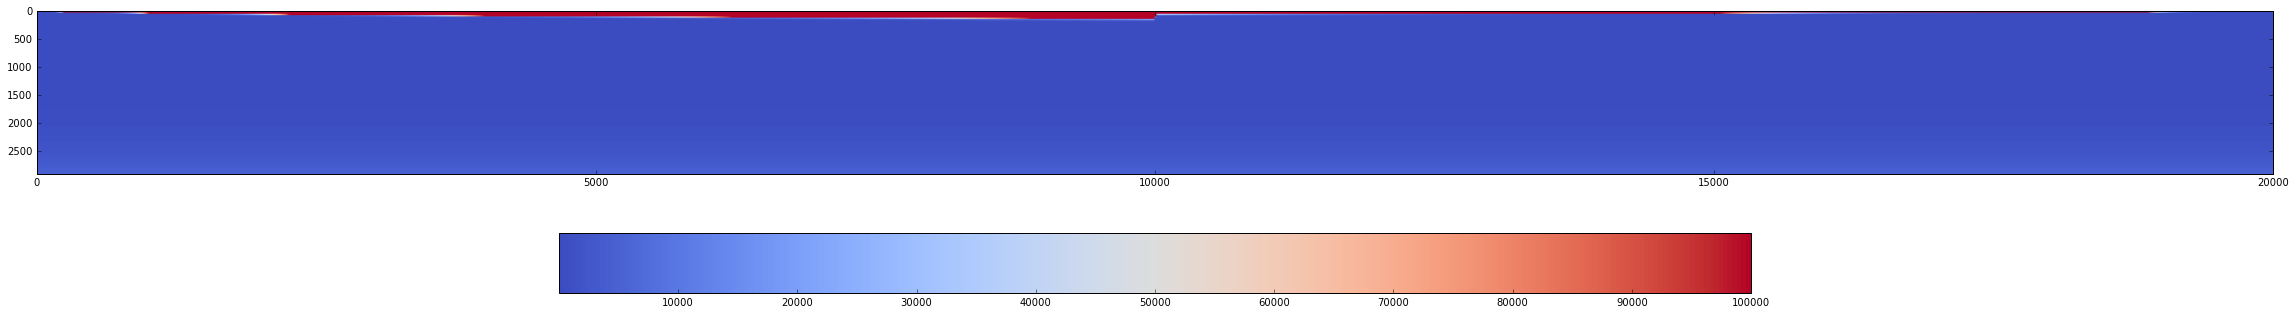

In [340]:
%pylab inline
import matplotlib.pylab as pyplt
field_data = safe_visc(diffusion).evaluate(mesh).reshape(mesh.elementRes[1] + 1, mesh.elementRes[0] + 1)
fig, ax = pyplt.subplots(figsize=(32,6))
ql = dp.LS/1e3
pyplt.ioff()
cax =ax.imshow(np.flipud(field_data), cmap='coolwarm', aspect = 0.5, extent=[0,ql*aspectRatio,ql, 0])
fig.colorbar(cax, orientation='horizontal' )
#ax.set_x([0,dp.LS*aspectRatio])
pyplt.tight_layout()

#return fig, ax
fig.show()

In [341]:
eba = np.load('visc_data1.npy')
ba = np.load('visc_data2.npy')

In [343]:
diff = eba - ba

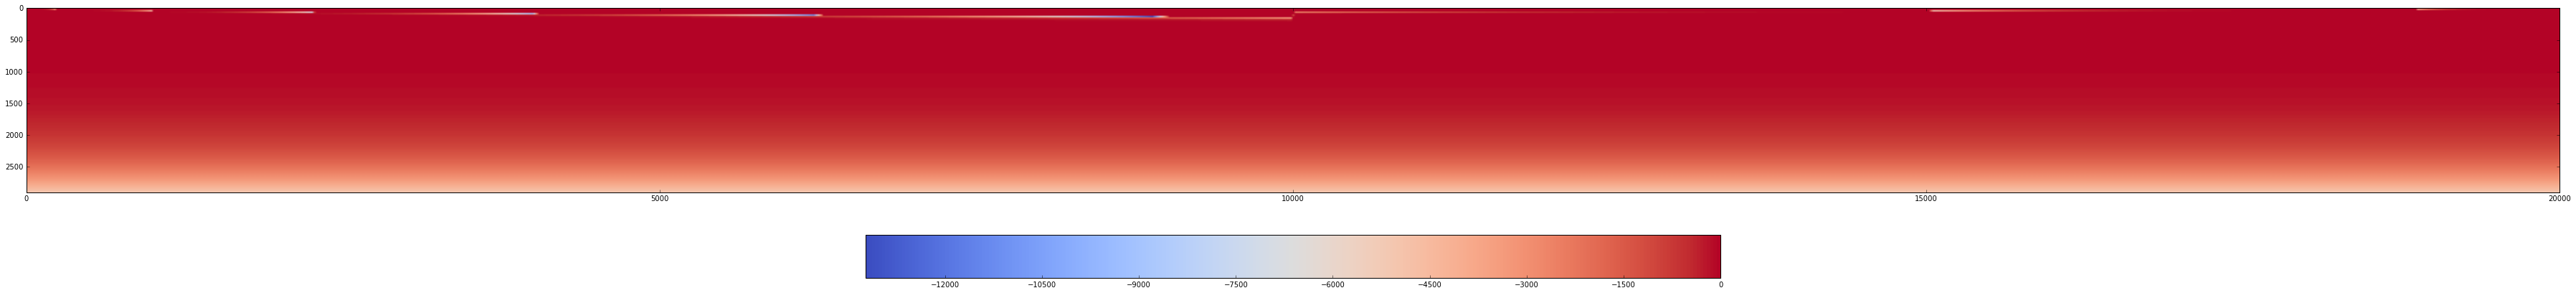

In [344]:
field_data = diff.reshape(mesh.elementRes[1] + 1, mesh.elementRes[0] + 1)
fig, ax = pyplt.subplots(figsize=(50,6))
ql = dp.LS/1e3
pyplt.ioff()
cax =ax.imshow(np.flipud(field_data), cmap='coolwarm', aspect = 0.5, extent=[0,ql*aspectRatio,ql, 0])
fig.colorbar(cax, orientation='horizontal' )
#ax.set_x([0,dp.LS*aspectRatio])
pyplt.tight_layout()
fig.savefig('test.png')


In [ ]:
#velocityField.data.max()

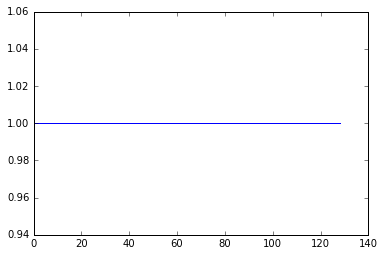

In [404]:
lWalls = mesh.specialSets["MinI_VertexSet"]
plt.plot(potTempFn.evaluate(lWalls))